In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use("fivethirtyeight")

In [4]:
def DF_DISP(df):
    display(HTML(df.to_html()))

## Load data gun data set
Dataset `guns` comes from https://github.com/fivethirtyeight/guns-data. It is a processed version of CDC's [Multiple Cause of Death datafile](http://www.cdc.gov/nchs/data_access/VitalStatsOnline.htm#Mortality_Multiple) from 2013. Columns are

> '', 'year', 'month', 'intent', 'police', 'sex', 'age', 'race', 'hispanic', 'place', 'education'

The first row is a redundant index, and I have no idea what the hispanic number is supposed to mean, thus both are dropped. The police colum is 1 if death is described as legal intervention involving firearm discharge. Education is encoded as 1: "Less than HS", 2: "HS/GED", 3: "Some college", 4:"BA+", 5:"N/A".  

In [5]:
# Read in guns data set, select usable columns
guns = pd.read_csv("data/guns.csv", usecols=["year", "month", "intent", "police", "sex", "age", "race", "place", "education"])
# Convert year, month to date time
guns["date"]=pd.to_datetime(guns["year"]*100+guns["month"],format='%Y%m')
# Convert education to strings
guns["education"] = guns["education"].dropna().apply(lambda x: {
   1: "Less than HS", 2:"HS/GED", 3: "Some college", 4:"BA+", 5:"N/A"}[x])
# Add a convenience column to count events
guns["count"] = 1

## Death rate vs time

First, a look of how death rate changes with time.

,count
year,
2012,33563
2013,33636
2014,33599


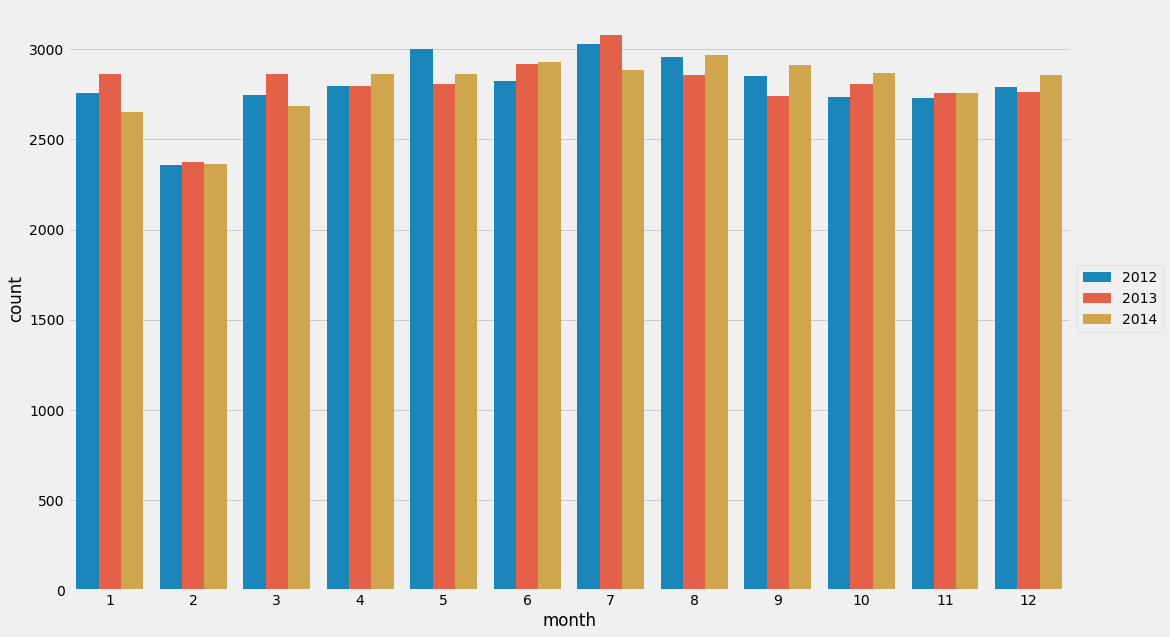

In [6]:
DF_DISP(guns.groupby(["year"])[["count"]].count())
fig, ax = plt.subplots(figsize=(16,10))
g = sns.countplot(x="month", hue="year", data=guns, ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Seems quite similar between years, and there is a significant dip in February. Even when compensating for that February is 7% shorter than an average month the dip remains.

Still the effect remains, perhaps there is something going on. Let's see if the `intent` is different. The most important intents are Suicide and Homicide which constitue 97% of deaths. We pivot table on `count` by `month` versus `intent`, then we calculate the rank of each column, sum the ranks over each row to `rsum`, and bake everything into one table.

In [7]:
month_intent = pd.pivot_table(guns, values="count", index=["month"], columns="intent", aggfunc="sum")
mirank = month_intent.rank()
mirank["rsum"] = mirank.sum(axis=1) # sum of ranks
month_intent = month_intent.join(mirank, rsuffix="_rank")
DF_DISP(month_intent)

intent,Accidental,Homicide,Suicide,Undetermined,Accidental_rank,Homicide_rank,Suicide_rank,Undetermined_rank,rsum
month,,,,,,,,,
1,152,2829,5220,72,9.0,3.0,4.0,7.5,23.5
2,127,2178,4732,56,5.0,1.0,1.0,2.0,9.0
3,134,2780,5309,66,7.0,2.0,6.0,5.0,20.0
4,98,2845,5438,73,1.0,4.0,10.0,9.5,24.5
5,115,2976,5506,72,3.0,8.0,11.0,7.5,29.5
6,112,3130,5367,68,2.0,10.0,8.0,6.0,26.0
7,149,3269,5514,57,8.0,12.0,12.0,3.0,35.0
8,164,3125,5421,73,11.0,9.0,9.0,9.5,38.5
9,118,2966,5343,81,4.0,6.0,7.0,12.0,29.0


So February is the lowest in the two most common intents Homicide and Suicide. Without additional data it is hard to tell why this might be.

## Male vs Female

The number of deaths varies with gender, lets count per gender and compare percentages

In [8]:
sex = guns.groupby("sex", as_index=False)[["count"]].count()
sex["percent"] = 100 * sex["count"] / sex["count"].sum()
DF_DISP(sex)

,sex,count,percent
0,F,14449,14.33461
1,M,86349,85.66539


In general, men with 86% of deaths are 6 times likelier to die of guns than women. How  does the pattern hold if we break it down by `intent`?

In [9]:
dd=pd.pivot_table(guns, values="count", index=["sex"], columns="intent", aggfunc="sum")
# Convert to percentage of gender
dd=pd.DataFrame(100*dd.values/sex["count"].values[:, None], index=dd.index, columns=dd.columns)
DF_DISP(dd)

intent,Accidental,Homicide,Suicide,Undetermined
sex,,,,
F,1.508755,37.185964,60.135650,1.169631
M,1.645647,34.514586,63.099746,0.738862


The rank order is identical, there are slightly fewer suicides and slightly more homocides in the female population. Somehow it seems men in general are just likelier to die of guns.

## Breakdown by race

In [10]:
race_counts = guns.groupby("race", as_index=False)[["count"]].count()
DF_DISP(race_counts)

,race,count
0,Asian/Pacific Islander,1326
1,Black,23296
2,Hispanic,9022
3,Native American/Native Alaskan,917
4,White,66237


At first glance race White is by far the dominant vicitims. However, the population in each race is not equal! 
We import some data from the [us census](https://www.census.gov/) and convert it to the groups above.

In [11]:
#  Data from t is included.
census = pd.read_csv("data/census.csv")
DF_DISP(census)

,Id,Year,Id.1,Sex,Id.2,Hispanic Origin,Id.3,Id2,Geography,Total,Race Alone - White,Race Alone - Hispanic,Race Alone - Black or African American,Race Alone - American Indian and Alaska Native,Race Alone - Asian,Race Alone - Native Hawaiian and Other Pacific Islander,Two or More Races
0,cen42010,"April 1, 2010 Census",totsex,Both Sexes,tothisp,Total,0100000US,NaN,United States,308745538,197318956,44618105,40250635,3739506,15159516,674625,6984195


In [12]:
mapping = {
    "Asian/Pacific Islander": census['Race Alone - Native Hawaiian and Other Pacific Islander'].sum()+census['Race Alone - Asian'].sum(),
    "Hispanic": census['Race Alone - Hispanic'].sum(),
    'Black': census['Race Alone - Black or African American'].sum(),
    "White": census['Race Alone - White'].sum(),
    'Native American/Native Alaskan': census['Race Alone - American Indian and Alaska Native'].sum()
}

Now we can measure the counts per 100,000 citizens in each group:

In [13]:
race_counts["per 100k"] = race_counts.apply(lambda x: x["count"]*100000/mapping[x["race"]], axis=1)
DF_DISP(race_counts)

,race,count,per 100k
0,Asian/Pacific Islander,1326,8.374310
1,Black,23296,57.877348
2,Hispanic,9022,20.220491
3,Native American/Native Alaskan,917,24.521956
4,White,66237,33.568493


So when correcting for population sizes it is clear that race Black is highly overrepresented. Looking at intent,

In [14]:
dd=pd.pivot_table(guns, values="count", index=["race"], columns="intent", aggfunc="sum")
DF_DISP(dd)

intent,Accidental,Homicide,Suicide,Undetermined
race,,,,
Asian/Pacific Islander,12,559,745,10
Black,328,19510,3332,126
Hispanic,145,5634,3171,72
Native American/Native Alaskan,22,326,555,14
White,1132,9147,55372,585


We see that Blacks predominantly are killed in Homicides, where as Whites predominantly are killed in Suicides. 